In [2]:
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

In [29]:
from utils import *

In [1]:
def generate_polymer(num_beads):
    # Initialize the polymer chain with the first bead at the origin
    polymer = np.zeros((num_beads, 3))
    
    # Generate random steps for each bead
    steps = np.random.randn(num_beads - 1, 3)
    steps /= np.linalg.norm(steps, axis=1)[:, np.newaxis]  # Normalize steps to unit length
    
    for i in range(1, num_beads):
        polymer[i] = polymer[i - 1] + steps[i - 1]
    
    return polymer


In [3]:
# Define parameters 
num_monomers = 100 
mean_bond_length = 1
std_bond_length = 10
gaussian_noise_std = 15

num_templates = 100
total_polymers = 10000
# num_observation_list = np.int32(np.linspace(10, 1000, num_templates))
num_observation_list = np.int32(np.ones(num_templates)) * 100

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]

observation_list = np.concatenate([*observation_list])

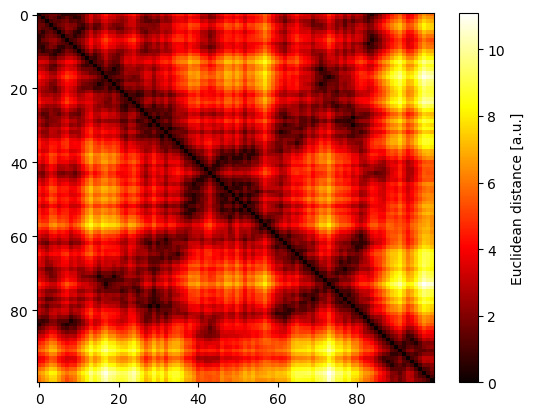

In [98]:
visualize_dmap(squareform(pdist(template_chain_list[4])))

In [4]:
labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
observation_flatten = np.array([squareform(pdist(x)).flatten() for x in observation_list])
print(observation_flatten.shape)

(10000, 10000)


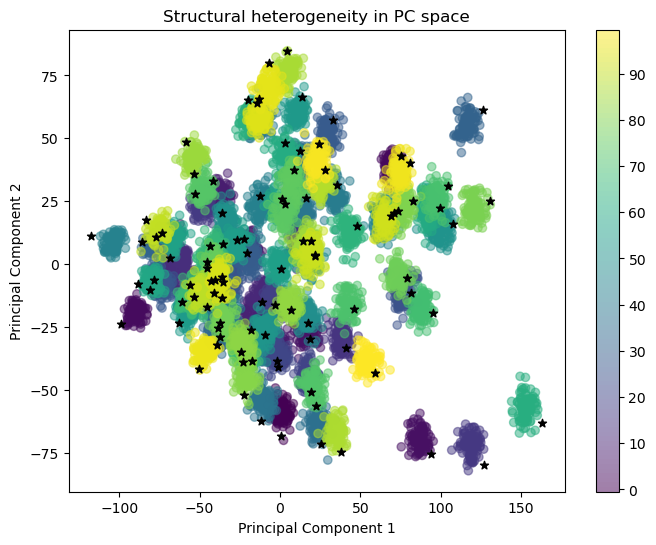

In [5]:
# Plot the PCA of these structures
# Create and fit the PCA model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)  # Reduce to 2 components
scaler = StandardScaler()
norm_observation_flatten = scaler.fit_transform(observation_flatten)
X_pca = pca.fit_transform(norm_observation_flatten)

true_template = np.array([squareform(pdist(x)).flatten() for x in template_chain_list])
scaler_true = StandardScaler()
true_template = scaler_true.fit_transform(true_template)
X_true_pca = pca.transform(true_template)

# Visualize the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_true, cmap='viridis', alpha=0.5)
plt.colorbar(boundaries=np.arange(101)-0.5).set_ticks(np.arange(0, 100, 10))
plt.scatter(X_true_pca[:, 0], X_true_pca[:, 1], marker='*', color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Structural heterogeneity in PC space')
# plt.savefig(save_folder+'PCA_true_cluster.png', dpi=300)
plt.show()

In [6]:
import umap 

# Apply UMAP with customized parameters
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=2, metric='euclidean', random_state=42)
umap_embedding = umap_model.fit_transform(norm_observation_flatten)
X_true_umap = umap_model.transform(true_template)

/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


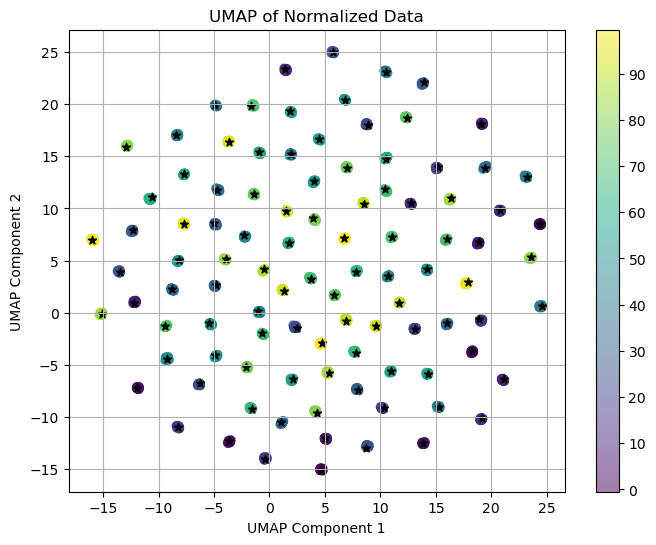

In [7]:
# Plot the UMAP components
plt.figure(figsize=(8, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=labels_true, cmap='viridis', alpha=0.5)
plt.colorbar(boundaries=np.arange(101)-0.5).set_ticks(np.arange(0, 100, 10))
plt.scatter(X_true_umap[:, 0], X_true_umap[:, 1], marker='*', color='black')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Normalized Data')
plt.grid()
plt.show()

In [8]:
X = np.array([squareform(pdist(x)).flatten() for x in observation_list])
Y = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])

# Shuffle data 
indices = np.arange(Y.shape[0])
np.random.shuffle(indices)
X_, Y_ = X[indices], Y[indices]

In [11]:
n_comp = 120

# Create and fit the Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(
    n_components=n_comp,      # Maximum number of components
    covariance_type='diag', # Type of covariance parameters
    max_iter=5000,         # Maximum number of iterations
    init_params='random',
    n_init=100,
    verbose=3
)
bgmm.fit(X_)

# Predict the labels of the data
labels_pred = bgmm.predict(X_)


Initialization 0
Initialization converged: True	 time lapse 6.52597s	 ll -16671668417.43757
Initialization 1
  Iteration 10	 time lapse 14.62345s	 ll change 1850878.36768
Initialization converged: True	 time lapse 20.16901s	 ll -16671668319.45274
Initialization 2
  Iteration 10	 time lapse 14.75265s	 ll change 206328851.21545
Initialization converged: True	 time lapse 17.55414s	 ll -16671668361.44624
Initialization 3
Initialization converged: True	 time lapse 5.12576s	 ll -16671668305.45491
Initialization 4
Initialization converged: True	 time lapse 8.17242s	 ll -16671668361.44624
Initialization 5
Initialization converged: True	 time lapse 9.26470s	 ll -16671667773.53726
Initialization 6
Initialization converged: True	 time lapse 6.44069s	 ll -16671668781.38123
Initialization 7
Initialization converged: True	 time lapse 13.31867s	 ll -16671668515.42241
Initialization 8
Initialization converged: True	 time lapse 10.80177s	 ll -16671667689.55026
Initialization 9
Initialization converged:

In [12]:
bgmm.converged_

True

In [13]:
labels_pred = bgmm.predict(X_)
AMI = sklearn.metrics.adjusted_mutual_info_score(Y_, labels_pred)

In [14]:
weights = bgmm.weights_
sort_index = np.argsort(weights)
sorted_weights = weights[sort_index]
true_weights = np.array(num_observation_list)/np.sum(num_observation_list)

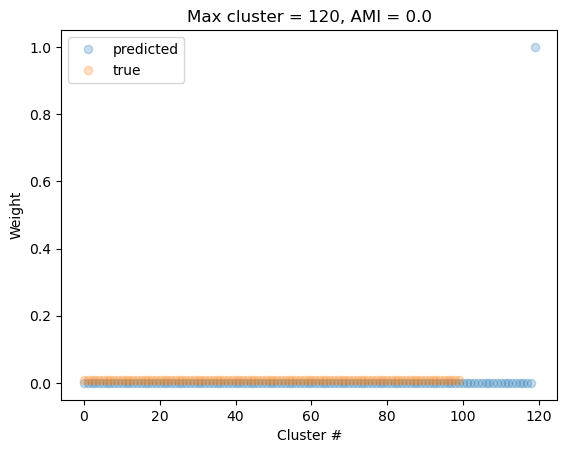

In [15]:
plt.plot(sorted_weights, 'o', alpha=0.25, label='predicted')
plt.plot(true_weights, 'o', alpha=0.25, label='true')
plt.xlabel('Cluster #')
plt.ylabel('Weight')
plt.title('Max cluster = {}, AMI = {}'.format(n_comp, np.round(AMI, 3)))
plt.legend()
# plt.savefig(save_folder+'weights_challenge_{}comp_diag_1.png'.format(n_comp), dpi=300)

In [25]:
means = bgmm.means_
true_dmaps = [squareform(pdist(x)).flatten() for x in template_chain_list]
pred_dmaps = means

In [26]:
pred_error_mat = cdist(pred_dmaps, true_dmaps)

In [27]:
row_ind, col_ind = linear_sum_assignment(pred_error_mat)

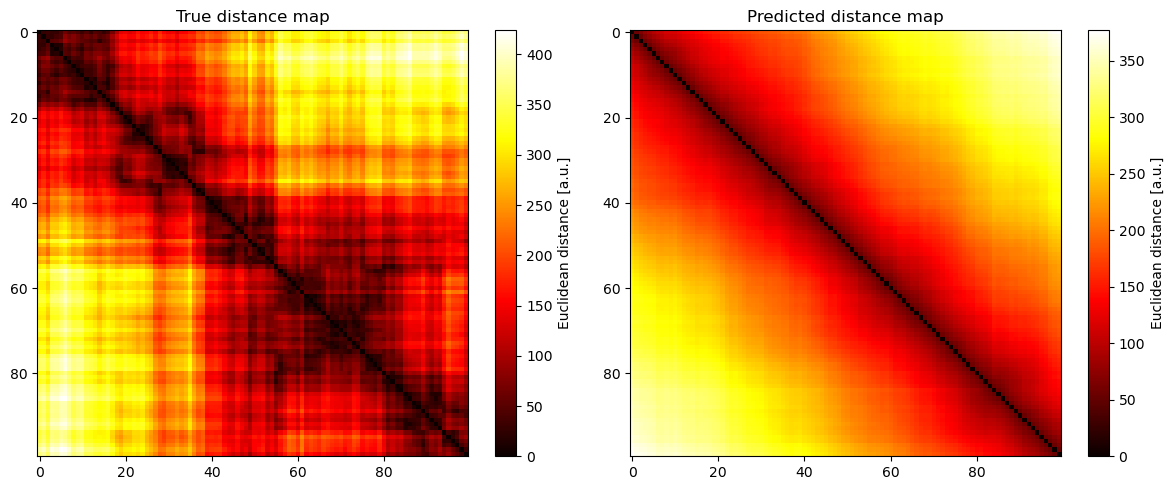

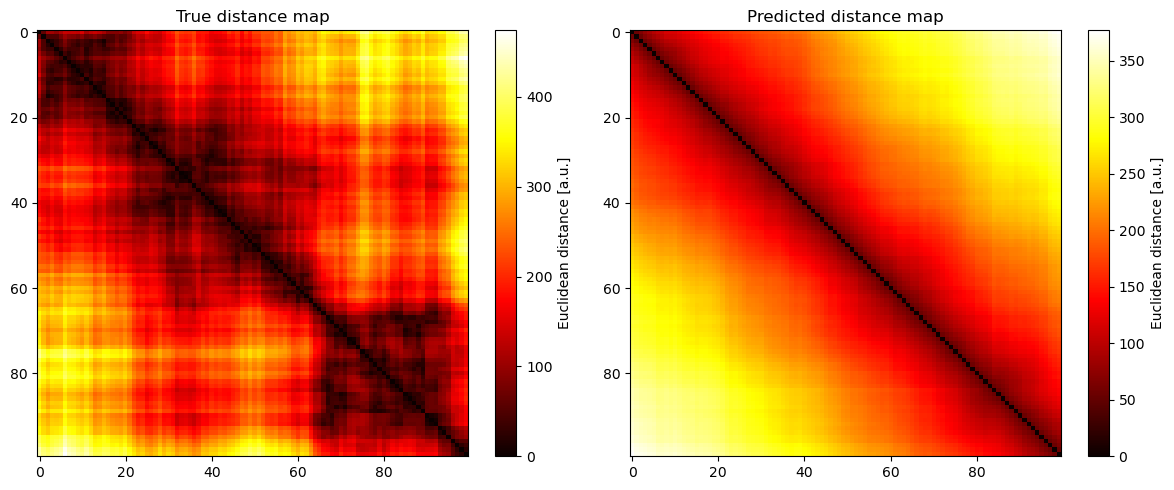

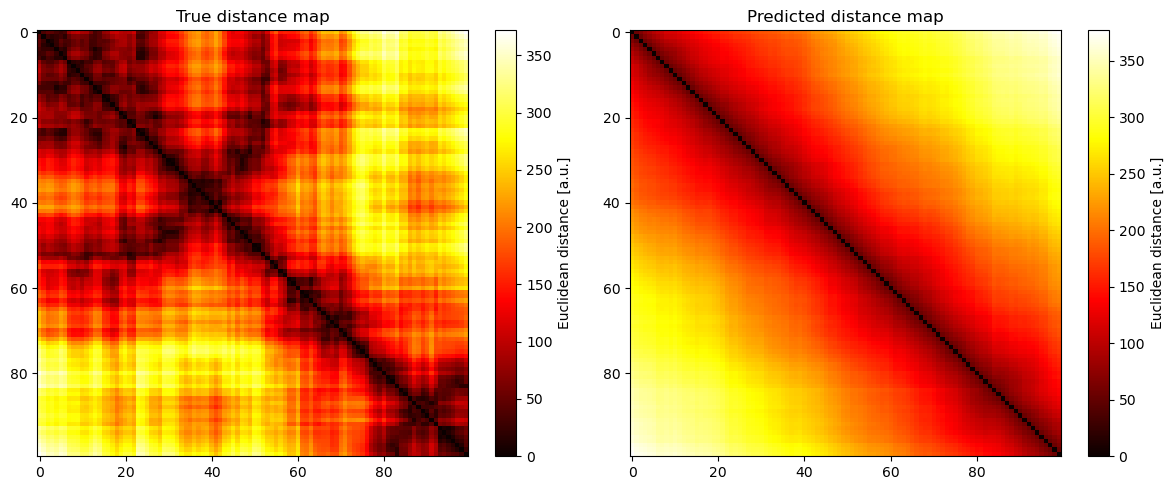

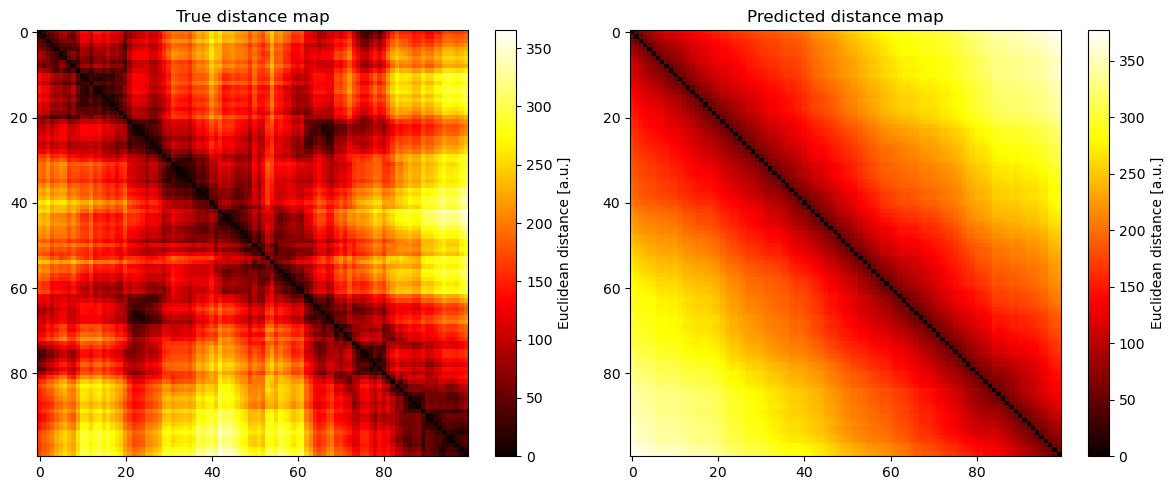

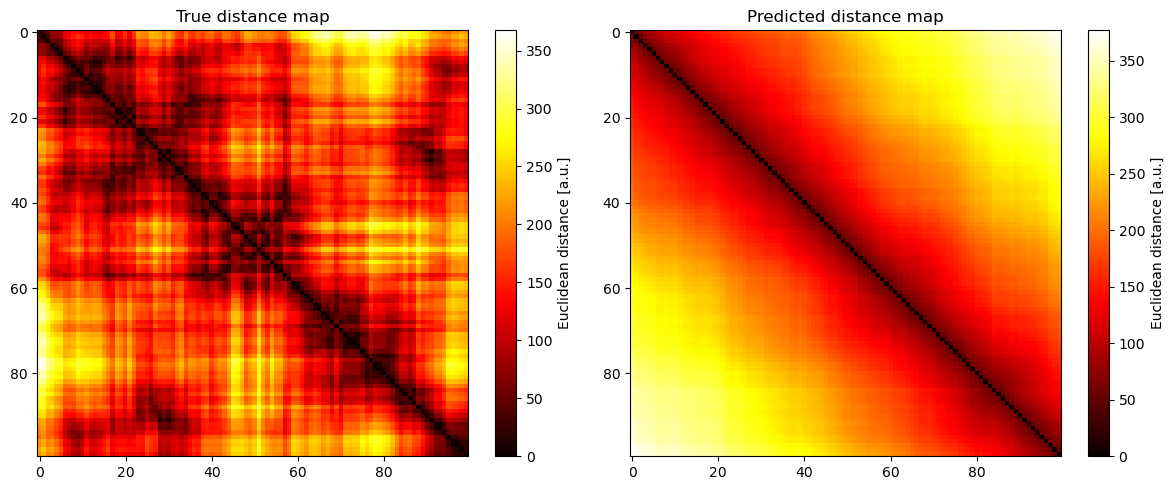

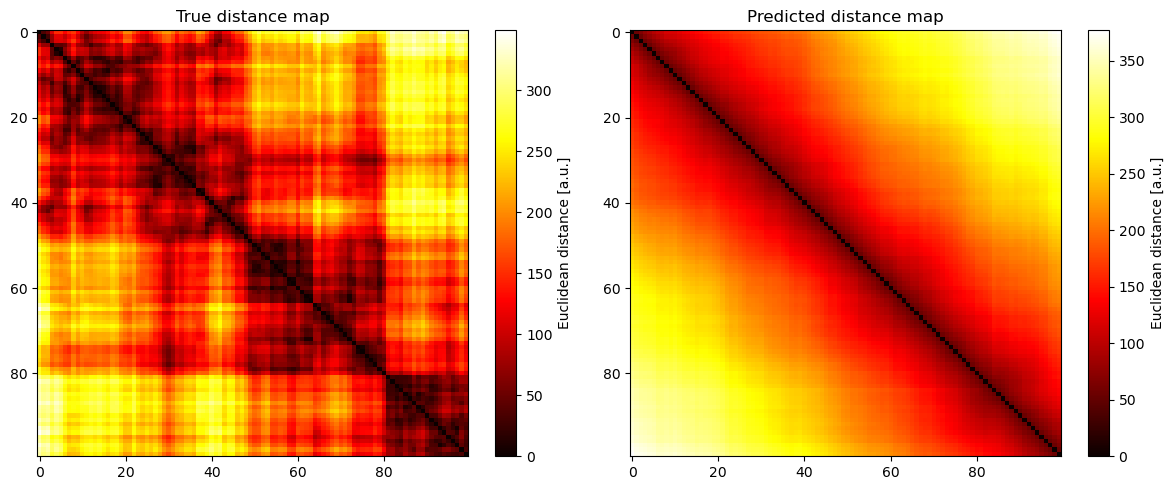

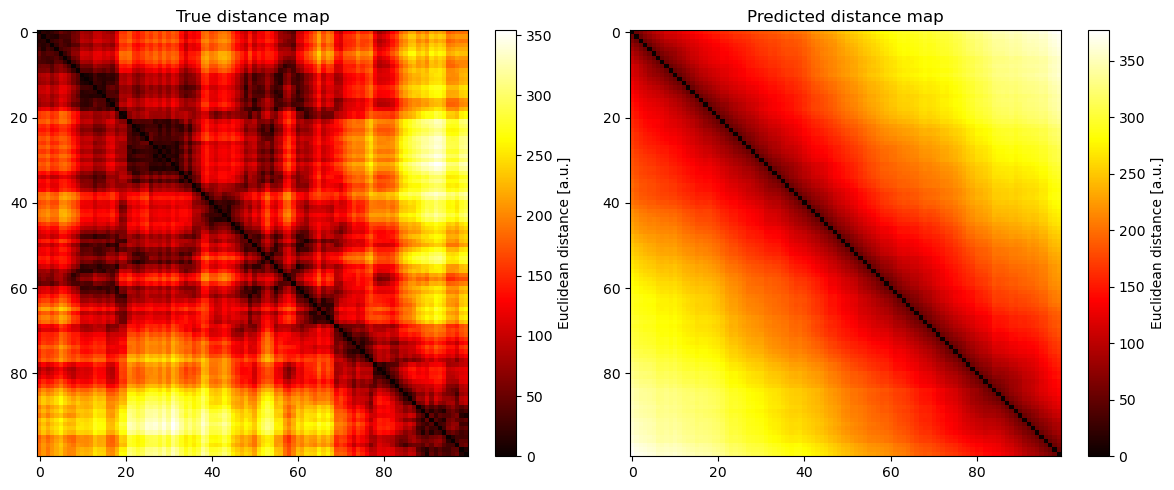

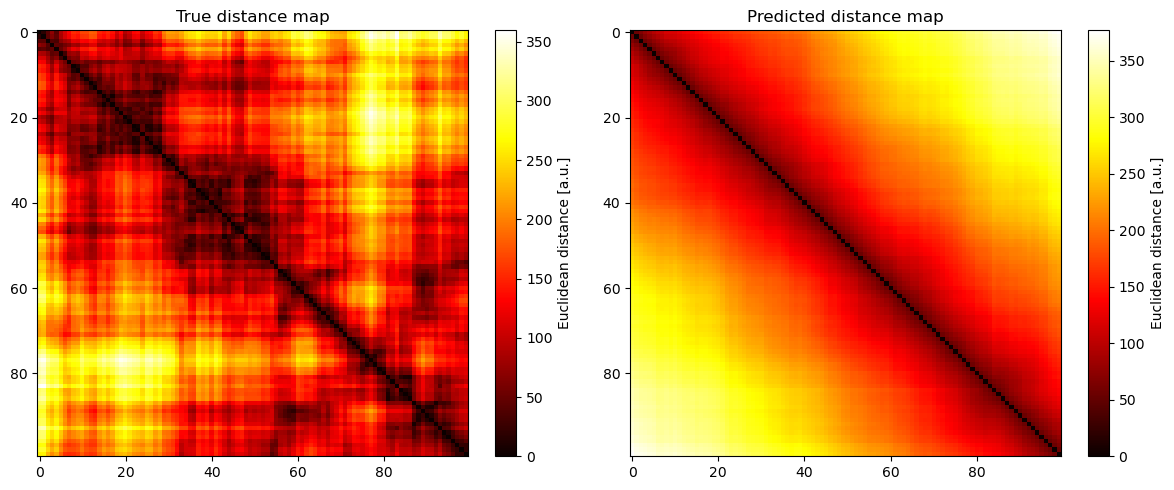

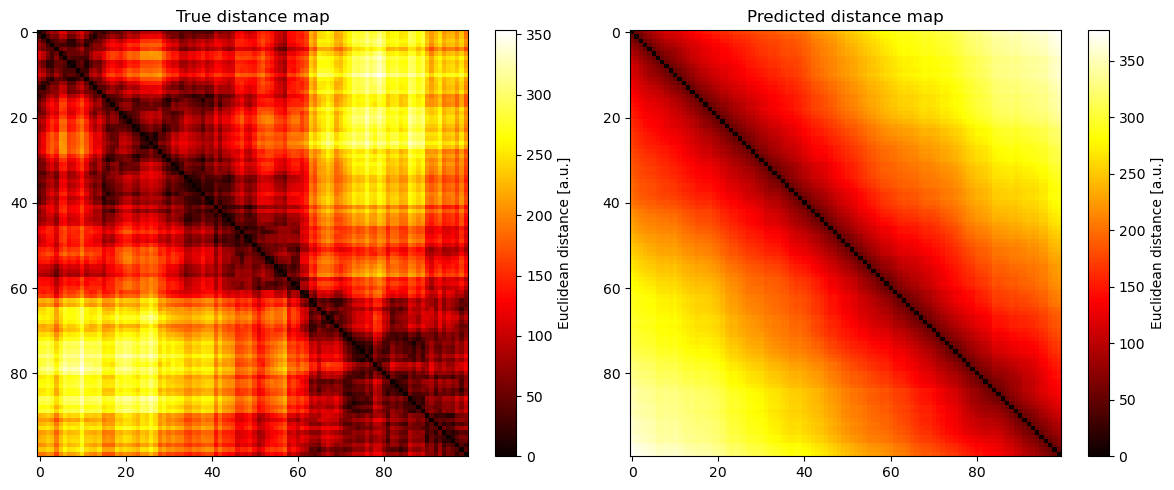

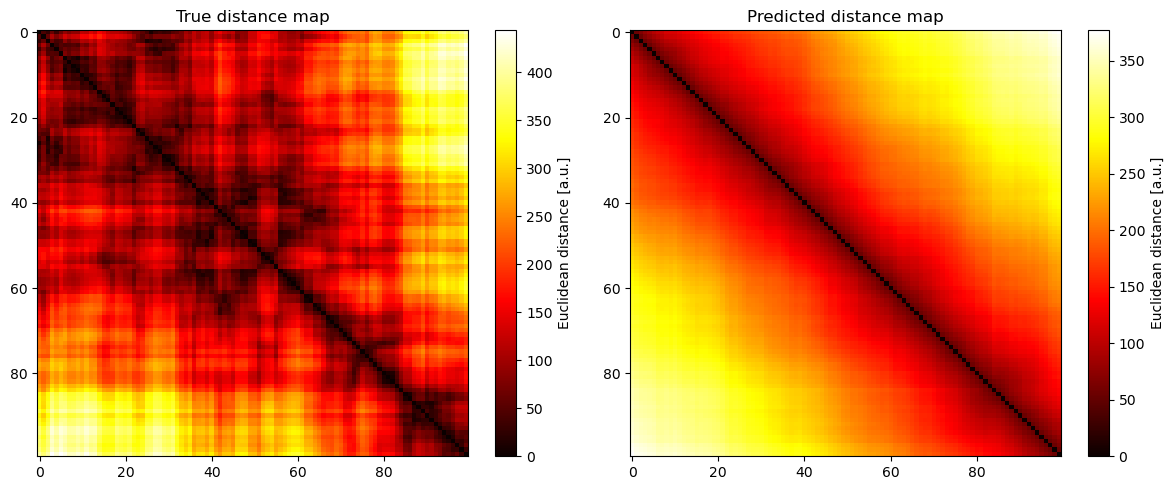

In [28]:
for i in range(0, 10): 
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    p1 = ax[0].imshow(true_dmaps[col_ind[i]].reshape(100, 100), cmap='hot', aspect='auto')
    cb1 = fig.colorbar(p1, ax=ax[0])
    cb1.set_label('Euclidean distance [a.u.]')
    ax[0].set_title('True distance map')
    p2 = ax[1].imshow(pred_dmaps[row_ind[i]].reshape(100, 100), cmap='hot', aspect='auto')
    cb2 = fig.colorbar(p2, ax=ax[1])
    cb2.set_label('Euclidean distance [a.u.]')
    ax[1].set_title('Predicted distance map')
    plt.tight_layout()
    # fig.savefig(save_folder+'dmap_assigned_pred{}_comp{}_diag.png'.format(i, n_comp), dpi=300)

In [1]:
from joblib import Parallel, delayed


In [10]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
from joblib import Parallel, delayed

# Define a function to fit the model
def fit_model(init_seed):
    bgm = BayesianGaussianMixture(n_components=120, 
                                  random_state=init_seed,
                                  init_params='random',
                                  verbose=3)
    bgm.fit(X_)
    return bgm

# Number of initializations
n_init = 100

# Use joblib to run the fitting process in parallel
models = Parallel(n_jobs=-1)(delayed(fit_model)(seed) for seed in tqdm(range(n_init)))

# Select the best model based on log likelihoodb
best_model = max(models, key=lambda model: model.lower_bound_)

  0%|          | 0/100 [00:00<?, ?it/s]

Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0


ERROR:concurrent.futures:exception calling callback for <Future at 0x15534d729d50 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}